# Task description

Goal:
- Build AEM electrolyzer system identification tool.

Given data:
- Electrolyzer stack voltage and current over time.

Plan:
1. Build electrolyzer model (= parametric equation of polarization curve).
2. Determine model parameters using part of given data.
3. Ensure parameters are correct using the other part of given data.

Electrolysis cell potential:
$$
E_{cell} = E_{rev} + E_{ohmic} + E_{activation} + E_{mass\_transfer}
$$
<img src="img/polarization-curve-detailed.png" width="40%"/>

### Reversible potential
> Source: https://doi.org/10.1016/j.ijhydene.2023.08.181 . But water activity $a_{\text{H}_2\text{O,KOH}}$ equation is incorrect in the source (lol. and what even more funny: numerous papers also contains this incorrect equation), so I took it from https://doi.org/10.1016/0360-3199(85)90093-X 

The reversible thermodynamic cell voltage, $E_{\text{rev}}$, is found using, which considers the effect of temperature, $T$, normalized partial pressures of the products, $P_{\text{H}_2}$ and $P_{\text{O}_2}$, and the activity of water, $a_{\text{H}_2\text{O}}$:
$$
E_{\text{rev}} = E_{\text{rev},T}^0 + \frac{RT}{2F} \ln \left( \frac{P_{\text{H}_2} \sqrt{P_{\text{O}_2}}}{a_{\text{H}_2\text{O}}} \right)
$$

When electrolysis is performed in KOH electrolytes (which are often used in the anode and cathode chambers of AEM water electrolyzers), the activities of $\text{H}_2$, $\text{O}_2$ and $\text{H}_2\text{O}$ are influenced by the properties of the KOH electrolyte:
$$
E_{\text{rev}} = E_{\text{rev},T}^0 + \frac{RT}{2F} \ln \left( \frac{(P - P_{\text{v,KOH}}) \sqrt{(P - P_{\text{v,KOH}})}}{a_{\text{H}_2\text{O,KOH}}} \right)
$$
where the ideal gas constant, $R = 8.314\ \text{J mol}^{-1}\text{K}^{-1}$, Faraday's constant, $F = 96,485\ \text{C mol}^{-1}$, $T$ is temperature (in K), $P$ is the operating pressure (in bar), $P_{\text{v,KOH}}$ is the water vapour pressure, and $a_{\text{H}_2\text{O,KOH}}$ is water activity in the KOH electrolyte. $E_{\text{rev},T}^0$ is the reversible voltage at standard pressure (1 bar), and is a function of temperature:
$$
E_{\text{rev},T}^0 = 1.5184 - 1.5421 \times 10^{-3} (T) + 9.523 \times 10^{-5} (T) \ln(T) + 9.84 \times 10^{-8} (T^2)
$$

The vapour pressure and the activity of water in KOH can be found by:
$$
P_{\text{v,KOH}} = e^{(2.302a + b \ln(P_{\text{v,H}_2\text{O}}))}
$$
$$
a = -0.0151m - 1.6788 \times 10^{-3}m^2 + 2.2588 \times 10^{-5}m^3
$$
$$
b = 1 - 1.2062 \times 10^{-3}m + 5.6024 \times 10^{-4}m^2 - 7.8228 \times 10^{-6}m^3
$$
$$
P_{\text{v,H}_2\text{O}} = \exp \left( \frac{81.6179 - 7699.68}{T} - 10.9 \ln(T) + 9.5891 \times 10^{-3} (T) \right)
$$
$$
a_{\text{H}_2\text{O,KOH}} = \exp \left( -0.02255 m + 0.001434 m^2 + \frac{1.38  m - 0.9254 m^2}{T} \right)
$$
where $m$ is the molar concentration of KOH (in mol $L^{-1}$).




In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy import constants
import matplotlib.pyplot as plt


In [3]:
def E_rev(T, P=35, m=1/5.61):
    # m -- molar concentration of KOH in mol/L. Mass concentration of KOH in Enapter electrolyzer = 1% => m = 1/5.61
    # P = 35 bar, from the Enapter docs 

    
    # Constants
    R = constants.R # J/(mol*K)
    F = constants.e * constants.N_A # C/mol

    E_rev_T0 = 1.5184 - 1.5421 * 10**(-3) * T + 9.523 * 10**(-5) * T * np.log(T) + 9.84 * 10**(-8) * T**2

    Pv_H2O = np.exp(81.6179 - 7699.68 / T - 10.9 * np.log(T) + 9.5891 * 10**(-3) * T)
    
    a = -0.01508*m - 1.6788 * 10**(-3) * m**2 + 2.2589 * 10**(-5) * m**3
    b = 1 - 1.2062 * 10**(-3) * m + 5.6024 * 10**(-4) * m**2 - 7.8228 * 10**(-6) * m**3
    
    Pv_KOH = np.exp(2.302 * a + b * np.log(Pv_H2O))
    
    # WRONG Calculation of aH2O,KOH 
    # WRONG_aH2O_KOH = -0.05192 * m + 0.003302 * m**2 + (3.177 * m - 2.131 * m**2) / T
    # print(WRONG_aH2O_KOH)
    
    aH2O_KOH = np.exp(-0.02255 * m + 0.001434 * m ** 2 + (1.38 * m - 0.9254* m**2) / T)
    
    E_rev = E_rev_T0 + (R * T / (2 * F)) * np.log((P - Pv_KOH) * np.sqrt(P - Pv_KOH) / aH2O_KOH)

    return E_rev

### Ohmic overpotential
> was helpful: https://doi.org/10.1016/j.jpowsour.2005.11.099

The voltage drop due to ohmic resistance can be found using:

$$
E_{\text{ohmic}} = j \times r
$$

where $j$ -- current density [A $m^{-2}$], $r$ -- cell resistance of the cell [Ohm $m^{2}$].

In [4]:
def E_ohmic(j, r):
    return j*r

### Activation overpotential
> Equations (20)-(23) from https://sci-hub.ru/10.1016/j.pecs.2009.11.002

The activation overpotentials for the oxygen evolution reaction (OER) (on cathode) and hydrogen evolution reaction (HER) (on anode) can be found using the Tafel equation:

$$
\eta_{\text{cathode}} = \frac{RT}{\alpha F} \log \left(\frac{j}{j_0}\right)
$$

$$
\eta_{\text{anode}} = \frac{RT}{(1 - \alpha) F} \log \left(\frac{j}{j_0}\right)
$$

where $j$ is current density [A $m^{-2}$], $j_0$ is exchange current density [A $m^{-2}$].

Thus, 
$$
E_{activation} = \eta_{\text{cathode}} + \eta_{\text{anode}}
$$

In [46]:
def E_activation(T, j, alpha, j_0):
    # Constants
    R = constants.R # J/(mol*K)
    F = constants.e * constants.N_A # C/mol
    
    # Calculate overpotentials
    eta_cathode = (R * T / (alpha * 2* F)) * np.log(j / j_0)
    eta_anode = (R * T / ((1- alpha) * 2*F)) * np.log(j / j_0)
    
    return eta_cathode + eta_anode

Finally, cell polarization curve equation:

In [44]:
def E_cell(j, T, j_0, alpha, r):
    return E_rev(T) + E_ohmic(j, r) + E_activation(T, j, alpha, j_0)


def draw_polarization_curves(j_values, T, j_0, alpha, r):
    E_rev_values = np.full_like(j_values, E_rev(T))  # E_rev is constant
    E_ohmic_values = E_ohmic(j_values, r)
    E_activation_values = E_activation(T, j_values, alpha, j_0)
    E_values = E_cell(j_values, T, j_0, alpha, r)
    
    # Plot the polarization curve
    plt.figure(figsize=(10, 6))
    plt.plot(j_values, E_values, label='Total Cell Potential', color='blue', linewidth=2)
    plt.plot(j_values, E_rev_values, '--', label='Reversible Potential', color='green', linewidth=1.5)
    plt.plot(j_values, E_ohmic_values, '--', label='Ohmic Potential', color='red', linewidth=1.5)
    plt.plot(j_values, E_activation_values, '--', label='Activation Potential', color='purple', linewidth=1.5)

    # Make the plot pretty
    plt.title('Polarization Curve', fontsize=16)
    plt.xlabel('Current density j (A/m$^2$)', fontsize=14)
    plt.ylabel('Potential E (Volts)', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

Quick evaluation of the model: let's draw a polarization curve with parameters derived by Saleh (he used slightly different model (wrong model)):

C:\Users\Rostyslav Kirchev\AppData\Local\Temp\ipykernel_7468\1132334274.py:7: RuntimeWarning: divide by zero encountered in log
  eta_cathode = (R * T / (alpha * 2* F)) * np.log(j / j_0)
C:\Users\Rostyslav Kirchev\AppData\Local\Temp\ipykernel_7468\1132334274.py:8: RuntimeWarning: divide by zero encountered in log
  eta_anode = (R * T / ((1- alpha) * 2*F)) * np.log(j / j_0)


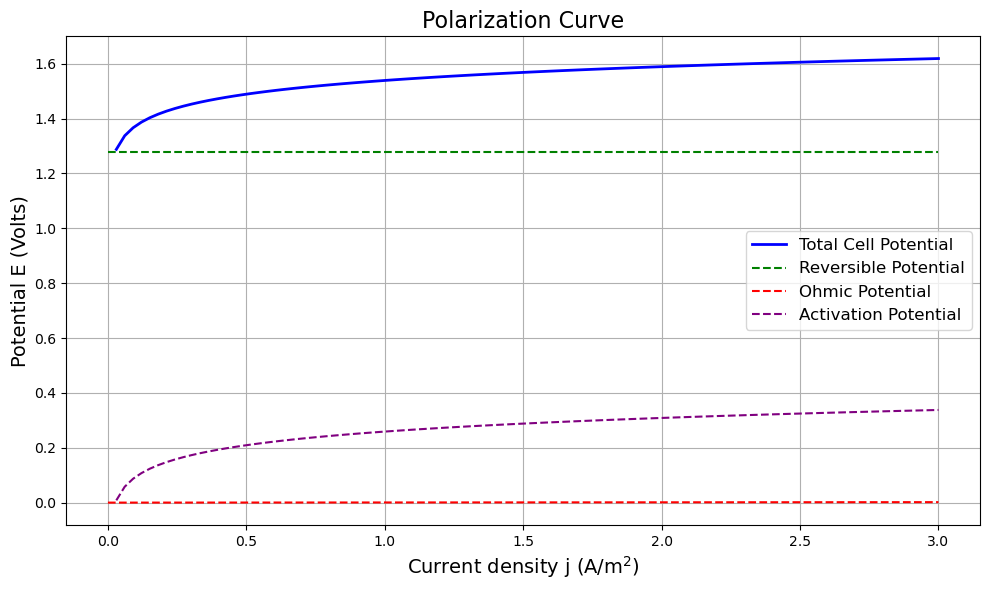

In [70]:
# According to Saleh's calculations:
j_0 = 0.027
alpha = 0.27
r = 5.76e-4

# Assumption:
T = 328 # 55C, standart operation temperature for the Enapter electrolyzer

j_values = np.linspace(0, 3, 100)

draw_polarization_curves(j_values, T, j_0, alpha, r)

Important points

- 1st Faraday law: m/Q = Z
where m is a mass of a substance deposited or liberate at an electrode, Q is a charge on electrode, Z is electro-chemical equivalent of the substance.
i.e. production rate is linear of stack/cell current

- 2nd Faraday law: M (molar mass)/ v (valence) = E (equivalent weight)

- V_cell = V_rev + V_ohm + V_act

In [10]:
# Your model function
def polarization_function(T_i, r, alpha, i_0):
    T, i = T_i
    
    V_0 = 1.229 - 8.5 * 10**(-4) * (T - 298)
    V_rev = V_0

    V_ohm = i * r
    faraday_constant = constants.e * constants.N_A

    V_act = 2 * ((constants.R * T) / (alpha * faraday_constant)) * np.arcsinh(i / i_0)

    return V_rev + V_ohm + V_act

T_data = np.array([your temperature measurements])
i_data = np.array([your current measurements])
u_data = np.array([your voltage measurements])

T_i_data = np.vstack((T_data, i_data))

popt, pcov = curve_fit(polarization_function, T_i_data, u_data)

r, alpha, i = popt 
print(f"Optimized parameters: r = {r}, alpha = {alpha}, i = {i}")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (449451698.py, line 16)